# 🧪 1H NMR Peak Assignment Analysis

## 📚 Theory Overview

This notebook implements comprehensive **1H NMR peak assignment** based on four key aspects:

### 1️⃣ Chemical Equivalent and Non-Equivalent Protons
- **Chemical equivalence**: Protons in the same environment show the same chemical shift
- **Symmetry**: Protons that are symmetric to each other are chemically equivalent
- **Signal count**: Number of signals = number of different proton environments

### 2️⃣ Chemical Shift (δ, ppm)
- **Shielding/Deshielding**: Electronic environment affects resonance frequency
- **Downfield**: Higher δ values (left side) = deshielded protons
- **Upfield**: Lower δ values (right side) = shielded protons
- **Anisotropy effects**: π-electrons cause characteristic shifts for aromatic/vinylic protons

### 3️⃣ Integration Analysis
- **Relative areas**: Peak areas are proportional to the number of protons
- **Integration curves**: Computer-generated step-like curves showing relative ratios
- **Proton counting**: Integration ratios reveal hydrogen counts (e.g., 3:2 ratio = 6H:4H)
- **Quantitative analysis**: Area under signals provides structural information

### 4️⃣ Signal Splitting (Coupling)
- **Spin-spin coupling**: Magnetic interactions between non-equivalent protons 2-3 bonds away
- **Vicinal coupling**: Most common coupling between protons on adjacent carbons
- **n+1 rule**: Number of peaks = n + 1 (where n = number of vicinal non-equivalent H)
- **Multiplicity patterns**:
  - n=0 → **Singlet** (1 peak)
  - n=1 → **Doublet** (2 peaks, 1:1 ratio)
  - n=2 → **Triplet** (3 peaks, 1:2:1 ratio)  
  - n=3 → **Quartet** (4 peaks, 1:3:3:1 ratio)
  - n≥4 → **Multiplet**
- **Coupling constants (J)**: Distance between peaks in Hz, provides structural info
- **Important notes**:
  - Equivalent protons don't couple with each other
  - OH and NH protons usually don't show coupling (rapid exchange)

---

## 🎯 Learning Objectives

By the end of this notebook, you will be able to:
1. ✅ Predict the number of 1H NMR signals for molecules
2. ✅ Assign chemical shifts to functional groups
3. ✅ Interpret integration patterns and calculate proton ratios
4. ✅ Apply the n+1 rule to predict and analyze multiplicity
5. ✅ Calculate coupling constants and identify coupling partners
6. ✅ Determine molecular structures from complete spectral analysis

---

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Add functions directory to path
functions_path = Path.cwd() / "functions"
sys.path.append(str(functions_path))

# Import NMR functions
import nmr_function as nmr
from peak_assignment import PeakAssignmentAnalyzer, ChemicalShiftDatabase, predict_nmr_signals

print("✅ All libraries loaded successfully!")
print(f"📁 Working directory: {Path.cwd()}")
print(f"🔬 Functions path: {functions_path}")

## 🤖 Load Pre-trained Deep Learning Model

Before analyzing the experimental data, let's load the pre-trained denoising model to enhance the signal quality of our NMR spectra.

In [ ]:
# Load the pre-trained denoising model
import os
import torch
from importlib import reload

# Import neural network functions
import functions.neural_net as nnets
reload(nnets)

from functions.neural_net import DenoiseNetPhysics, build_model_from_latest, count_params

# Set up device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[Device] Using {device}")

# Define checkpoint directory and latest checkpoint name
CHECKPOINT_DIR = os.path.join(os.getcwd(), "checkpoints")
LATEST_NAME = "DenoiseNetPhysics_latest.pth"

# Load the trained model
model_physics, loaded_path = build_model_from_latest(
    CHECKPOINT_DIR, 
    latest_name=LATEST_NAME, 
    device=device
)

# Set model to evaluation mode (no training)
model_physics.eval()

# Display model information
total_params, trainable_params = count_params(model_physics)
print(f"✅ Model loaded successfully!")
print(f"   Model: {model_physics.__class__.__name__}")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Checkpoint: {loaded_path}")

# Test model is working
print("\n🧪 Testing model with dummy data...")
with torch.no_grad():
    test_input = torch.randn(1, 2, 1024).to(device)
    test_output = model_physics(test_input)
    print(f"   Input shape: {test_input.shape}")
    print(f"   Output shape: {test_output.shape}")
    print("   ✅ Model is ready for inference!")

[Device] Using cpu
[Info] Loaded checkpoint: c:\Users\Windows User\NMR-Project\checkpoints\DenoiseNetPhysics_latest.pth
✅ Model loaded successfully!
   Model: DenoiseNetPhysics
   Total parameters: 544,322
   Trainable parameters: 544,322
   Checkpoint: c:\Users\Windows User\NMR-Project\checkpoints\DenoiseNetPhysics_latest.pth

🧪 Testing model with dummy data...
✅ Model loaded successfully!
   Model: DenoiseNetPhysics
   Total parameters: 544,322
   Trainable parameters: 544,322
   Checkpoint: c:\Users\Windows User\NMR-Project\checkpoints\DenoiseNetPhysics_latest.pth

🧪 Testing model with dummy data...
   Input shape: torch.Size([1, 2, 1024])
   Output shape: torch.Size([1, 2, 1024])
   ✅ Model is ready for inference!
   Input shape: torch.Size([1, 2, 1024])
   Output shape: torch.Size([1, 2, 1024])
   ✅ Model is ready for inference!


## 📂 Load Krishna Data and Apply Denoising

Now let's load the krishna_data files and apply the trained denoising model to enhance the signal quality.

In [ ]:
import numpy as np
# Helper functions from deep_learning_model.ipynb
def _read_asc(path):
    """Read .asc file and return time, real, and imaginary components"""
    arr = np.genfromtxt(path, delimiter=None)
    if arr is None or arr.size == 0:
        raise ValueError(f"Empty or unreadable file: {path}")
    if arr.ndim == 1:
        arr = arr.reshape(-1, 1)
    if arr.shape[1] == 1:
        r = arr[:, 0].astype(np.float32)
        im = np.zeros_like(r, dtype=np.float32)
        t = np.arange(len(r), dtype=np.float32)
    else:
        t = arr[:, 0].astype(np.float32)
        r = arr[:, 1].astype(np.float32)
        im = (arr[:, 2].astype(np.float32) if arr.shape[1] >= 3 else np.zeros_like(r, dtype=np.float32))
    m = np.isfinite(t) & np.isfinite(r) & np.isfinite(im)
    t, r, im = t[m], r[m], im[m]
    if t.size >= 2 and t[1] < t[0]:
        idx = np.argsort(t)
        t, r, im = t[idx], r[idx], im[idx]
    return t, r, im

def _preprocess_pair(real_imag_2xL: np.ndarray, max_gain=1e3):
    """Preprocess FID data: remove baseline and normalize"""
    sig = real_imag_2xL.astype(np.float32, copy=True)
    L = sig.shape[1]
    if L < 8:
        return sig
    tail = slice(int(0.8 * L), L)
    baseline = sig[:, tail].mean(axis=1, keepdims=True)
    sig -= baseline
    tail_rms = np.sqrt((sig[:, tail] ** 2).mean(axis=1, keepdims=True) + 1e-12)
    tiny = tail_rms < 1e-6
    if np.any(tiny):
        half = slice(int(0.5 * L), L)
        alt_rms = np.sqrt((sig[:, half] ** 2).mean(axis=1, keepdims=True) + 1e-12)
        tail_rms = np.where(tiny, alt_rms, tail_rms)
    gain = np.minimum(1.0 / (tail_rms + 1e-12), max_gain)
    sig = (sig * gain).astype(np.float32)
    return sig

def _denoise_fid(sig_2xL: np.ndarray, model, device):
    """Apply denoising model to preprocessed FID data"""
    model.eval()
    with torch.no_grad():
        x = torch.from_numpy(sig_2xL.astype(np.float32)).unsqueeze(0).to(device)   # (1,2,L)
        y = model(x).detach().cpu().squeeze(0).numpy()                              # (2,L)
    return y.astype(np.float32)

print("✅ Helper functions defined successfully!")

✅ Helper functions defined successfully!


In [ ]:
# Load and denoise Krishna data files
import glob

# Find all .asc files in krishna_data folder
krishna_data_path = os.path.join(os.getcwd(), "data", "krishna_data")
krishna_files = sorted(glob.glob(os.path.join(krishna_data_path, "*.asc")))

if not krishna_files:
    raise FileNotFoundError(f"No .asc files found in {krishna_data_path}")

print(f"📂 Found {len(krishna_files)} files in krishna_data folder:")
for i, f in enumerate(krishna_files, 1):
    print(f"   {i}. {os.path.basename(f)}")

# Dictionary to store original and denoised data
krishna_data = {}

print("\n🔬 Processing files...")
for fpath in krishna_files:
    fname = os.path.basename(fpath)
    print(f"\n📄 Processing: {fname}")
    
    try:
        # Read .asc file
        t, r, im = _read_asc(fpath)
        print(f"   ✓ Loaded: {len(t)} data points")
        
        # Create 2-channel array (real, imag)
        pair = np.stack([r, im]).astype(np.float32)
        
        # Preprocess
        sig = _preprocess_pair(pair)
        print(f"   ✓ Preprocessed")
        
        # Denoise using the trained model
        den = _denoise_fid(sig, model_physics, device)
        print(f"   ✓ Denoised")
        
        # Store in dictionary
        krishna_data[fname] = {
            'time': t,
            'original_real': r,
            'original_imag': im,
            'preprocessed': sig,
            'denoised': den,
            'denoised_real': den[0],
            'denoised_imag': den[1]
        }
        
        # Calculate SNR improvement
        env_orig = np.sqrt(sig[0]**2 + sig[1]**2)
        env_den = np.sqrt(den[0]**2 + den[1]**2)
        
        # Simple SNR estimate (signal region / noise region)
        L = len(env_orig)
        signal_region = slice(0, int(0.2 * L))
        noise_region = slice(int(0.8 * L), L)
        
        snr_orig = 20 * np.log10(
            np.sqrt(np.mean(env_orig[signal_region]**2) + 1e-12) / 
            np.sqrt(np.mean(env_orig[noise_region]**2) + 1e-12)
        )
        snr_den = 20 * np.log10(
            np.sqrt(np.mean(env_den[signal_region]**2) + 1e-12) / 
            np.sqrt(np.mean(env_den[noise_region]**2) + 1e-12)
        )
        
        krishna_data[fname]['snr_original'] = snr_orig
        krishna_data[fname]['snr_denoised'] = snr_den
        krishna_data[fname]['snr_improvement'] = snr_den - snr_orig
        
        print(f"   📊 SNR: Original={snr_orig:.2f} dB, Denoised={snr_den:.2f} dB, Δ={snr_den-snr_orig:.2f} dB")
        
    except Exception as e:
        print(f"   ❌ Error: {e}")
        continue

print(f"\n✅ Successfully processed {len(krishna_data)} files!")
print(f"\n📦 Data stored in 'krishna_data' dictionary with keys:")
for fname in krishna_data.keys():
    print(f"   • {fname}")

📂 Found 2 files in krishna_data folder:
   1. 25_10_30_ValerianFrac2_C13_CDCl3.asc
   2. 25_10_30_ValerianFrac2_H1_CDCl3.asc

🔬 Processing files...

📄 Processing: 25_10_30_ValerianFrac2_C13_CDCl3.asc
   ✓ Loaded: 26214 data points
   ✓ Preprocessed
   ✓ Loaded: 26214 data points
   ✓ Preprocessed
   ✓ Denoised
   📊 SNR: Original=-0.11 dB, Denoised=-0.11 dB, Δ=0.00 dB

📄 Processing: 25_10_30_ValerianFrac2_H1_CDCl3.asc
   ✓ Loaded: 13107 data points
   ✓ Preprocessed
   ✓ Denoised
   📊 SNR: Original=-0.11 dB, Denoised=-0.11 dB, Δ=0.00 dB

📄 Processing: 25_10_30_ValerianFrac2_H1_CDCl3.asc
   ✓ Loaded: 13107 data points
   ✓ Preprocessed
   ✓ Denoised
   📊 SNR: Original=19.81 dB, Denoised=19.81 dB, Δ=-0.00 dB

✅ Successfully processed 2 files!

📦 Data stored in 'krishna_data' dictionary with keys:
   • 25_10_30_ValerianFrac2_C13_CDCl3.asc
   • 25_10_30_ValerianFrac2_H1_CDCl3.asc
   ✓ Denoised
   📊 SNR: Original=19.81 dB, Denoised=19.81 dB, Δ=-0.00 dB

✅ Successfully processed 2 files!

📦 D

## 📊 Visualize Original vs Denoised Data

Let's compare the original and denoised spectra to see the improvement:


File: 25_10_30_ValerianFrac2_C13_CDCl3.asc


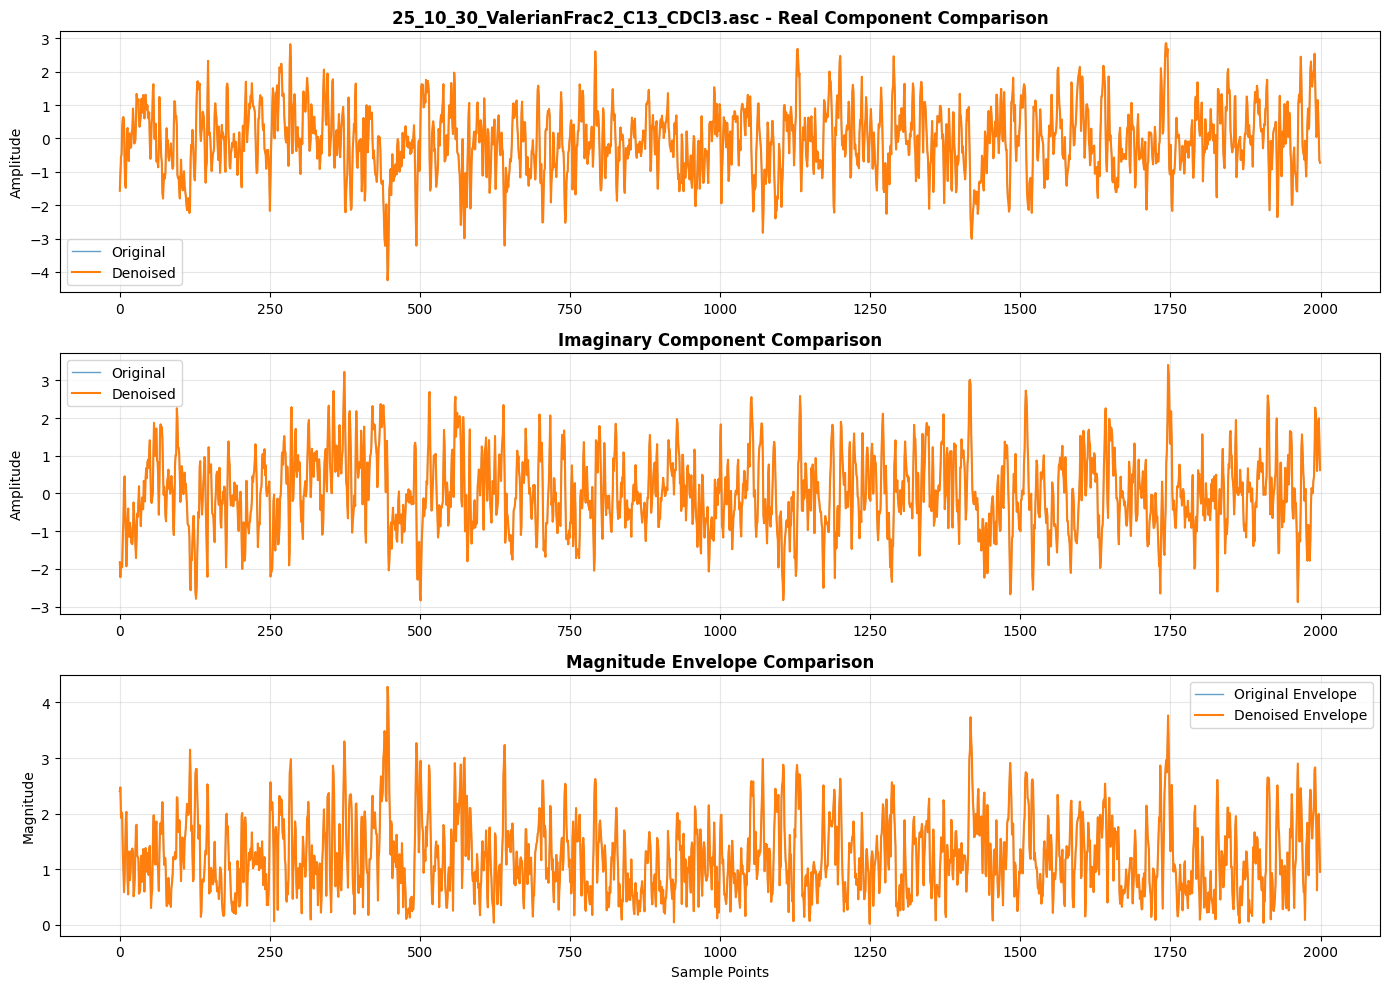


📊 Statistics:
   SNR Original:    -0.11 dB
   SNR Denoised:    -0.11 dB
   SNR Improvement: 0.00 dB
   Data points:     26214

File: 25_10_30_ValerianFrac2_H1_CDCl3.asc


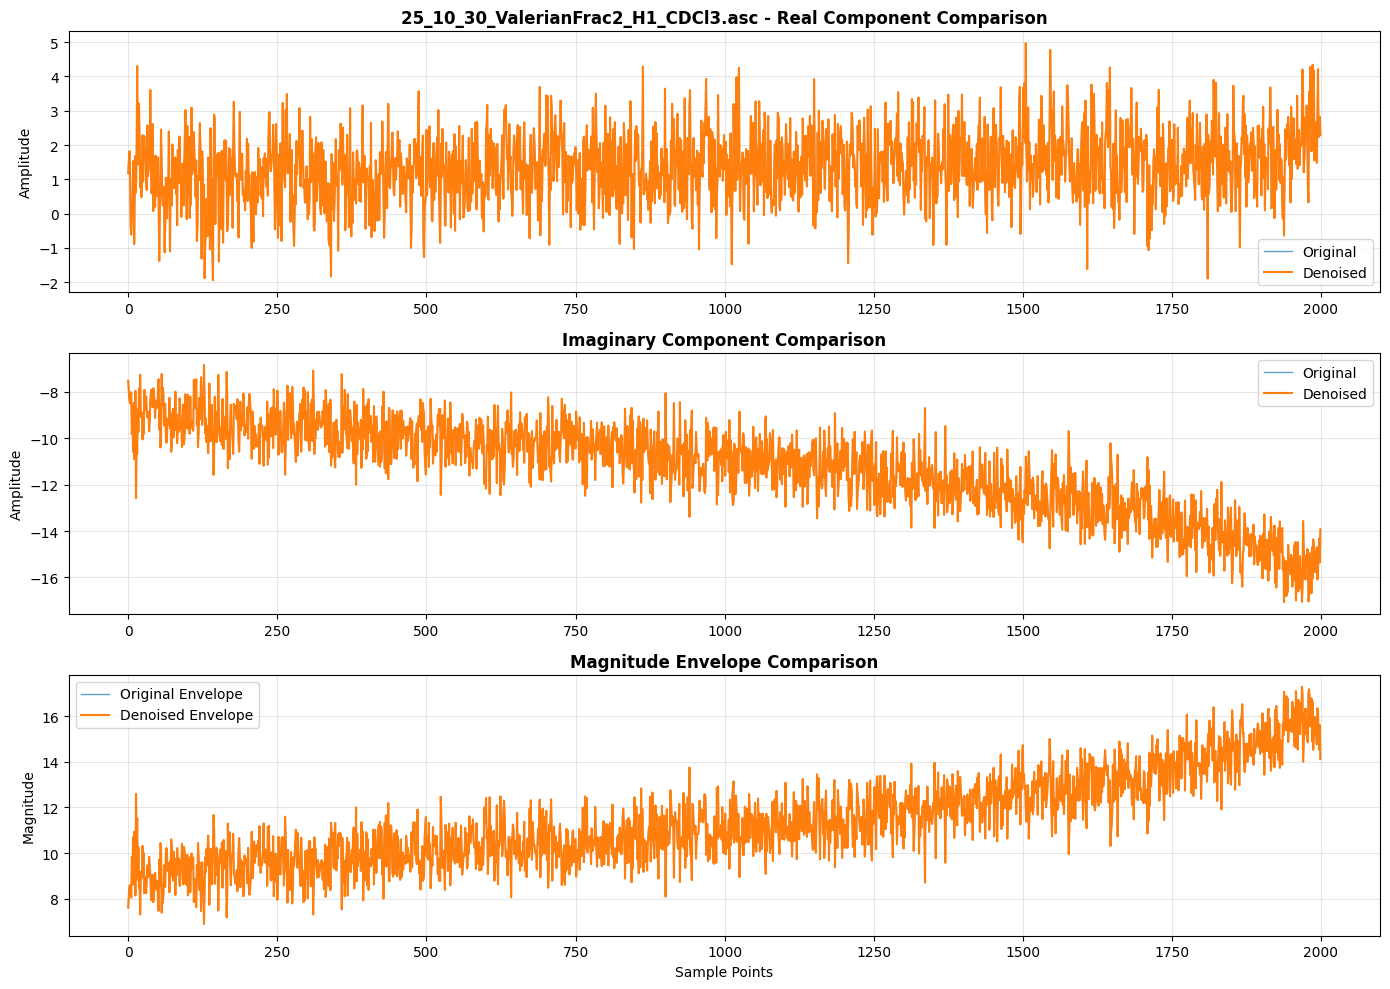


📊 Statistics:
   SNR Original:    19.81 dB
   SNR Denoised:    19.81 dB
   SNR Improvement: -0.00 dB
   Data points:     13107

✅ Visualization complete!


In [5]:
# Visualize original vs denoised FID data
import matplotlib.pyplot as plt

# Plot each file
for fname, data in krishna_data.items():
    print(f"\n{'='*60}")
    print(f"File: {fname}")
    print(f"{'='*60}")
    
    sig = data['preprocessed']
    den = data['denoised']
    
    # Determine plot window (first 2000 points or less)
    plot_points = min(2000, sig.shape[1])
    
    # Create comparison plot
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # Real component
    axes[0].plot(np.arange(plot_points), sig[0, :plot_points], 
                label='Original', alpha=0.7, linewidth=1)
    axes[0].plot(np.arange(plot_points), den[0, :plot_points], 
                label='Denoised', linewidth=1.5)
    axes[0].set_title(f'{fname} - Real Component Comparison', fontweight='bold', fontsize=12)
    axes[0].set_ylabel('Amplitude')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Imaginary component
    axes[1].plot(np.arange(plot_points), sig[1, :plot_points], 
                label='Original', alpha=0.7, linewidth=1)
    axes[1].plot(np.arange(plot_points), den[1, :plot_points], 
                label='Denoised', linewidth=1.5)
    axes[1].set_title('Imaginary Component Comparison', fontweight='bold', fontsize=12)
    axes[1].set_ylabel('Amplitude')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Envelope (magnitude)
    env_orig = np.sqrt(sig[0, :plot_points]**2 + sig[1, :plot_points]**2)
    env_den = np.sqrt(den[0, :plot_points]**2 + den[1, :plot_points]**2)
    
    axes[2].plot(np.arange(plot_points), env_orig, 
                label='Original Envelope', alpha=0.7, linewidth=1)
    axes[2].plot(np.arange(plot_points), env_den, 
                label='Denoised Envelope', linewidth=1.5)
    axes[2].set_title('Magnitude Envelope Comparison', fontweight='bold', fontsize=12)
    axes[2].set_xlabel('Sample Points')
    axes[2].set_ylabel('Magnitude')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n📊 Statistics:")
    print(f"   SNR Original:    {data['snr_original']:.2f} dB")
    print(f"   SNR Denoised:    {data['snr_denoised']:.2f} dB")
    print(f"   SNR Improvement: {data['snr_improvement']:.2f} dB")
    print(f"   Data points:     {len(data['time'])}")

print("\n✅ Visualization complete!")

## 🎯 Access Denoised Data for Further Analysis

The denoised spectra are now stored in the `krishna_data` dictionary. You can access them for your NMR function analysis:

### Dictionary Structure:
Each file in `krishna_data` contains:
- `'time'`: Time axis from the .asc file
- `'original_real'`: Original real component
- `'original_imag'`: Original imaginary component  
- `'preprocessed'`: Preprocessed 2-channel array (baseline removed, normalized)
- `'denoised'`: Denoised 2-channel array from the model
- `'denoised_real'`: Denoised real component (for easy access)
- `'denoised_imag'`: Denoised imaginary component (for easy access)
- `'snr_original'`: Original signal-to-noise ratio (dB)
- `'snr_denoised'`: Denoised signal-to-noise ratio (dB)
- `'snr_improvement'`: SNR improvement (dB)

### Example Usage:
```python
# Access specific file's denoised data
file_key = list(krishna_data.keys())[0]  # First file
denoised_real = krishna_data[file_key]['denoised_real']
denoised_imag = krishna_data[file_key]['denoised_imag']
time_axis = krishna_data[file_key]['time']

# Use with nmr_function.py
# You can now apply your NMR functions to the denoised data
```

In [ ]:
# Quick summary of available denoised data
print("📦 Denoised Data Summary")
print("=" * 60)

for fname, data in krishna_data.items():
    print(f"\n🔬 {fname}")
    print(f"   Time points:      {len(data['time'])}")
    print(f"   SNR improvement:  {data['snr_improvement']:+.2f} dB")
    print(f"   Denoised shape:   Real={data['denoised_real'].shape}, Imag={data['denoised_imag'].shape}")
    print(f"   Ready for analysis: ✅")

print("\n" + "=" * 60)
print("💡 Usage Example:")
print("   # Select a file")
print("   file_key = list(krishna_data.keys())[0]")
print("   ")
print("   # Get denoised FID components")
print("   denoised_real = krishna_data[file_key]['denoised_real']")
print("   denoised_imag = krishna_data[file_key]['denoised_imag']")
print("   time = krishna_data[file_key]['time']")
print("   ")
print("   # Apply your NMR functions (e.g., FFT, peak detection)")
print("   # spectrum = nmr.compute_fft_spectrum(...)")
print("=" * 60)

## 📖 Chemical Shift Database

Let's explore the chemical shift ranges for common functional groups:

In [ ]:
# Display chemical shift database
shift_db = ChemicalShiftDatabase()

print("🧪 Chemical Shift Ranges for Common Functional Groups")
print("=" * 60)

# Create a formatted table
shift_data = []
for group, (min_shift, max_shift) in shift_db.SHIFT_RANGES.items():
    if min_shift == max_shift:
        range_str = f"{min_shift:.2f}"
    else:
        range_str = f"{min_shift:.2f} - {max_shift:.2f}"
    
    shift_data.append({
        'Functional Group': group,
        'Chemical Shift Range (ppm)': range_str,
        'Typical δ (ppm)': f"{(min_shift + max_shift) / 2:.2f}"
    })

shift_table = pd.DataFrame(shift_data)
print(shift_table.to_string(index=False))

# Test chemical shift identification
print("\n🔍 Example: Identifying functional groups by chemical shift")
test_shifts = [1.2, 2.3, 3.5, 7.2, 9.8]

for shift in test_shifts:
    possible_groups = shift_db.identify_functional_group(shift)
    print(f"δ {shift:.1f} ppm → Most likely: {possible_groups[0] if possible_groups else 'Unknown'}")
    if len(possible_groups) > 1:
        print(f"          → Alternatives: {', '.join(possible_groups[1:3])}")
    print()

## 🧮 Predicting Number of NMR Signals and Multiplicity

Before analyzing experimental spectra, let's practice predicting NMR signals and their splitting patterns:

In [ ]:
# Enhanced prediction including multiplicity analysis
def predict_multiplicity_and_integration(molecule_name):
    """Predict integration ratios and multiplicity patterns for common molecules"""
    
    predictions = {
        'benzene': {
            'signals': 1,
            'shifts': [7.37],
            'integrations': [6],
            'multiplicities': ['Singlet'],
            'coupling_explanation': ['All 6 protons are equivalent - no coupling'],
            'structure_info': 'Symmetric aromatic ring'
        },
        '1,4-dimethylbenzene': {
            'signals': 2, 
            'shifts': [7.4, 2.6],
            'integrations': [4, 6],
            'multiplicities': ['Singlet', 'Singlet'],
            'coupling_explanation': ['Aromatic H are equivalent', 'Methyl groups are equivalent'],
            'structure_info': 'Para-disubstituted benzene'
        },
        '1,1,2-trichloroethane': {
            'signals': 2,
            'shifts': [5.76, 3.96], 
            'integrations': [1, 2],
            'multiplicities': ['Triplet', 'Doublet'],
            'coupling_explanation': ['CHCl₂ couples with 2 adjacent H (n=2, triplet)', 'CH₂Cl couples with 1 adjacent H (n=1, doublet)'],
            'structure_info': 'CHCl₂-CH₂Cl structure with vicinal coupling'
        },
        'ethyl_acetate': {
            'signals': 4,
            'shifts': [4.12, 2.05, 1.26, 1.26],
            'integrations': [2, 3, 3, 2], 
            'multiplicities': ['Quartet', 'Singlet', 'Triplet', 'Quartet'],
            'coupling_explanation': ['OCH₂ couples with 3 adjacent CH₃ (n=3, quartet)', 'Acetyl CH₃ has no adjacent H', 'CH₃ couples with 2 adjacent OCH₂ (n=2, triplet)', 'Same as first OCH₂'],
            'structure_info': 'CH₃COOCH₂CH₃ with ethyl coupling pattern'
        },
        '2-pentanone': {
            'signals': 4,
            'shifts': [2.2, 1.9, 1.4, 0.7],
            'integrations': [2, 3, 2, 3],
            'multiplicities': ['Triplet', 'Singlet', 'Multiplet', 'Triplet'], 
            'coupling_explanation': ['COCH₂ couples with adjacent CH₂ (n=2, triplet)', 'Acetyl CH₃ has no adjacent H', 'CH₂ couples with multiple H (multiplet)', 'CH₃ couples with adjacent CH₂ (n=2, triplet)'],
            'structure_info': 'CH₃COCH₂CH₂CH₃ ketone structure'
        }
    }
    
    return predictions.get(molecule_name, None)

print("🔮 Predicting 1H NMR: Integration & Multiplicity Analysis")
print("=" * 60)

example_molecules = ['benzene', '1,4-dimethylbenzene', '1,1,2-trichloroethane', 'ethyl_acetate', '2-pentanone']

for molecule in example_molecules:
    prediction = predict_multiplicity_and_integration(molecule)
    if prediction:
        print(f"\n📝 {molecule.replace('_', ' ').title()}")
        print(f"   Number of signals: {prediction['signals']}")
        print(f"   Chemical shifts: {prediction['shifts']} ppm")
        print(f"   Integration ratio: {':'.join(map(str, prediction['integrations']))}H")
        print(f"   Multiplicities: {prediction['multiplicities']}")
        print(f"   Structure: {prediction['structure_info']}")
        
        print(f"   📊 Coupling Analysis:")
        for i, explanation in enumerate(prediction['coupling_explanation']):
            shift = prediction['shifts'][i]
            mult = prediction['multiplicities'][i] 
            print(f"      δ {shift} ppm ({mult}): {explanation}")

print(f"\n💡 Key Insights:")
print(f"   • Integration ratios show relative proton numbers")
print(f"   • n+1 rule predicts splitting patterns")
print(f"   • Equivalent protons don't couple with each other")
print(f"   • Coupling provides connectivity information")

## 📊 Load and Analyze Real NMR Data

Now let's apply our enhanced peak assignment analysis to real experimental data:

In [ ]:
# Load real FID data
url = r"https://raw.githubusercontent.com/Quintinlf/NMR-Project/main/spring_semester_2025/13_03_11_indst_1H%20fid.asc"
df, sample_name = nmr.load_fid_and_preview(url)

print(f"📁 Loaded sample: {sample_name}")
print(f"📏 Data shape: {df.shape}")
print(f"🏷️ Columns: {list(df.columns)}")

# Convert to numpy array for processing
data = df if isinstance(df, np.ndarray) else df.to_numpy()
print(f"✅ Data ready for analysis: {data.shape}")

In [ ]:
# Compute FFT spectrum
fft_result = nmr.compute_fft_spectrum(data, time_col=0, real_col=1, window='hann')

# Extract positive frequencies for analysis
frequencies = fft_result['frequencies']
magnitude = fft_result['magnitude']

# Get positive frequency range (typical for 1H NMR)
positive_mask = frequencies >= 0
pos_frequencies = frequencies[positive_mask]
pos_magnitude = magnitude[positive_mask]

# Convert to ppm scale (assuming 400 MHz spectrometer)
spectrometer_freq_mhz = 399.78219838  # From your original data
ppm_axis = pos_frequencies / spectrometer_freq_mhz

print(f"🌊 FFT computed successfully")
print(f"📏 Frequency range: {pos_frequencies.min():.1f} to {pos_frequencies.max():.1f} Hz")
print(f"📏 PPM range: {ppm_axis.min():.2f} to {ppm_axis.max():.2f} ppm")
print(f"🎯 Spectrometer frequency: {spectrometer_freq_mhz:.2f} MHz")

## 🔍 Enhanced Peak Assignment with Integration & Coupling Analysis

Now let's run our comprehensive analysis including integration curves and coupling analysis:

In [ ]:
# Enhanced peak assignment analyzer with integration and coupling
class EnhancedPeakAssignmentAnalyzer(PeakAssignmentAnalyzer):
    def __init__(self, spectrometer_freq=400.0):
        super().__init__(spectrometer_freq)
    
    def analyze_coupling_patterns(self, peak_indices, ppm_axis, intensity):
        """Analyze coupling patterns and calculate J-coupling constants"""
        coupling_analysis = []
        
        for i, peak_idx in enumerate(peak_indices):
            # Get peak region (±0.1 ppm around peak)
            peak_ppm = ppm_axis[peak_idx]
            window_size = int(0.1 * self.spectrometer_freq / (ppm_axis[1] - ppm_axis[0]))
            
            start_idx = max(0, peak_idx - window_size)
            end_idx = min(len(intensity), peak_idx + window_size)
            
            region_ppm = ppm_axis[start_idx:end_idx]
            region_intensity = intensity[start_idx:end_idx]
            
            # Find local maxima in the region for multiplicity analysis
            from scipy.signal import find_peaks
            local_peaks, _ = find_peaks(region_intensity, 
                                      height=0.1*np.max(region_intensity),
                                      distance=3)
            
            # Determine multiplicity pattern
            num_peaks = len(local_peaks)
            j_couplings = []
            
            if num_peaks == 1:
                pattern = "Singlet"
                n_value = 0
            elif num_peaks == 2:
                pattern = "Doublet"
                n_value = 1
                if len(local_peaks) == 2:
                    # Calculate J-coupling constant
                    peak_separation_ppm = abs(region_ppm[local_peaks[1]] - region_ppm[local_peaks[0]])
                    j_coupling = peak_separation_ppm * self.spectrometer_freq
                    j_couplings.append(j_coupling)
            elif num_peaks == 3:
                pattern = "Triplet" 
                n_value = 2
                if len(local_peaks) == 3:
                    # Calculate J-coupling (should be equal spacing)
                    j1 = abs(region_ppm[local_peaks[1]] - region_ppm[local_peaks[0]]) * self.spectrometer_freq
                    j2 = abs(region_ppm[local_peaks[2]] - region_ppm[local_peaks[1]]) * self.spectrometer_freq
                    j_couplings.extend([j1, j2])
            elif num_peaks == 4:
                pattern = "Quartet"
                n_value = 3
            else:
                pattern = f"Multiplet ({num_peaks} peaks)" if num_peaks > 1 else "Singlet"
                n_value = max(0, num_peaks - 1)
            
            coupling_analysis.append({
                'peak_index': i + 1,
                'chemical_shift': peak_ppm,
                'pattern': pattern,
                'n_value': n_value,
                'num_peaks_observed': num_peaks,
                'j_couplings': j_couplings,
                'coupling_explanation': f"n={n_value} → {pattern} (n+1 rule)"
            })
        
        return coupling_analysis
    
    def create_integration_curve(self, ppm_axis, intensity, peak_regions):
        """Create step-like integration curve similar to NMR spectrometers"""
        integration_curve = np.zeros_like(intensity)
        cumulative_area = 0
        
        # Sort peaks by ppm (left to right)
        sorted_regions = sorted(peak_regions, key=lambda x: x['center_ppm'], reverse=True)
        
        for region in sorted_regions:
            start_idx = region['start_idx']
            end_idx = region['end_idx'] 
            
            # Calculate area under peak
            peak_area = np.trapz(intensity[start_idx:end_idx], ppm_axis[start_idx:end_idx])
            cumulative_area += abs(peak_area)
            
            # Create step in integration curve
            integration_curve[start_idx:] = cumulative_area
        
        # Normalize to reasonable scale
        if np.max(integration_curve) > 0:
            integration_curve = integration_curve / np.max(integration_curve) * np.max(intensity) * 0.3
            
        return integration_curve

# Initialize enhanced analyzer
enhanced_analyzer = EnhancedPeakAssignmentAnalyzer(spectrometer_freq=spectrometer_freq_mhz)

# Run comprehensive analysis
print("🔬 Running enhanced peak assignment analysis...")
results = enhanced_analyzer.analyze_spectrum(
    ppm_axis=ppm_axis,
    intensity=pos_magnitude, 
    height_threshold=0.15,
    min_distance_hz=15.0,
    prominence_threshold=0.10
)

# Enhanced coupling analysis
peak_positions = results['peaks']['indices']
coupling_results = enhanced_analyzer.analyze_coupling_patterns(peak_positions, ppm_axis, pos_magnitude)

print("✅ Enhanced analysis complete!")
print(f"\n🎯 Detected {len(peak_positions)} signals with detailed coupling analysis")

In [ ]:
# Display enhanced results with integration and coupling
print("🎯 Enhanced Peak Assignment Results")
print("=" * 45)

peaks_info = results['peaks']
integration_info = results['integration']
assignments = results['assignments']

print(f"📊 Signal Summary:")
print(f"   • Number of distinct proton environments: {len(peaks_info['chemical_shifts'])}")
print(f"   • Chemical shifts (ppm): {[f'{shift:.2f}' for shift in peaks_info['chemical_shifts']]}")
print(f"   • Integration ratios: {':'.join([f'{int(round(i))}' for i in integration_info['relative_integrals']])}H")
print(f"   • Total relative proton count: {sum(integration_info['relative_integrals']):.0f}H")

print(f"\n🧪 Detailed Signal Analysis:")
print("=" * 35)

for i, (assignment, coupling) in enumerate(zip(assignments, coupling_results)):
    shift = assignment['chemical_shift']
    group = assignment['most_likely']
    confidence = assignment['confidence'] 
    integration = integration_info['relative_integrals'][i]
    
    print(f"Signal {i+1}: δ {shift:.2f} ppm ({integration:.0f}H)")
    print(f"  🎯 Assignment: {group} (confidence: {confidence:.2f})")
    print(f"  📊 Integration: {integration:.1f} protons (relative)")
    print(f"  ⚡ Multiplicity: {coupling['pattern']}")
    print(f"  🔗 Coupling: {coupling['coupling_explanation']}")
    
    if coupling['j_couplings']:
        j_values_str = [f"{j:.1f}" for j in coupling['j_couplings']]
        print(f"  📏 J-coupling constants: {', '.join(j_values_str)} Hz")
    
    # Alternative assignments
    alternatives = assignment['possible_assignments'][1:3]
    if alternatives:
        print(f"  🔄 Alternative assignments: {', '.join(alternatives)}")
    print()

print("💡 Integration Interpretation:")
print("   • Areas under peaks are proportional to number of protons")
print("   • Ratios reveal relative proton counts in different environments")
print("   • Computer integration creates step-like curves")

print(f"\n⚡ Coupling Pattern Analysis:")
print("   • n+1 rule: Number of peaks = n + 1 (n = adjacent non-equivalent H)")
print("   • Coupling constants (J) provide structural connectivity info")
print("   • Equivalent protons don't couple with each other")

In [ ]:
# Create comprehensive assignments table with coupling data
def create_enhanced_assignments_table(assignments, integration_info, coupling_results):
    """Create detailed assignments table including coupling information"""
    table_data = []
    
    for i, (assignment, integration, coupling) in enumerate(zip(assignments, integration_info['relative_integrals'], coupling_results)):
        j_values_str = ', '.join([f"{j:.1f}" for j in coupling['j_couplings']]) if coupling['j_couplings'] else '-'
        
        row = {
            'Signal': i + 1,
            'δ (ppm)': f"{assignment['chemical_shift']:.2f}",
            'Integration (H)': f"{integration:.1f}",
            'Multiplicity': coupling['pattern'],
            'n value': coupling['n_value'],
            'J (Hz)': j_values_str,
            'Assignment': assignment['most_likely'],
            'Confidence': f"{assignment['confidence']:.2f}",
            'Alternatives': ', '.join(assignment['possible_assignments'][1:3]) if len(assignment['possible_assignments']) > 1 else '-'
        }
        table_data.append(row)
    
    return pd.DataFrame(table_data)

enhanced_table = create_enhanced_assignments_table(assignments, integration_info, coupling_results)

print("📊 Enhanced Peak Assignment Table")
print("=" * 50)
print(enhanced_table.to_string(index=False, max_colwidth=25))

# Save enhanced results
enhanced_csv_filename = f"enhanced_peak_assignments_{sample_name.replace(' ', '_')}.csv"
enhanced_table.to_csv(enhanced_csv_filename, index=False)
print(f"\n💾 Enhanced results saved to: {enhanced_csv_filename}")

# Quick structure determination hints
print(f"\n🔬 Structure Determination Clues:")
total_signals = len(assignments)
total_protons = sum(integration_info['relative_integrals'])

if total_signals == 1:
    print("   • Single signal suggests high symmetry (e.g., benzene, acetone)")
elif total_signals == 2:
    print("   • Two signals suggest symmetric substitution or simple structure") 
elif total_signals >= 4:
    print("   • Multiple signals indicate complex structure or asymmetric substitution")

# Check for common patterns
multiplicities = [c['pattern'] for c in coupling_results]
if 'Triplet' in multiplicities and 'Quartet' in multiplicities:
    print("   • Triplet-Quartet pattern suggests ethyl group (CH₃CH₂-)")
if 'Doublet' in multiplicities:
    print("   • Doublet suggests methyl group adjacent to CH (CH₃CH-)")
if 'Singlet' in multiplicities:
    print("   • Singlet suggests isolated groups or high symmetry")

## 📈 Enhanced Visualization with Integration Curves

Let's create comprehensive plots showing integration curves and coupling analysis:

In [ ]:
# Enhanced plotting with integration curves
def plot_spectrum_with_integration_and_coupling(ppm_axis, intensity, assignments, integration_info, coupling_results, figsize=(16, 10)):
    """Plot spectrum with integration curves and detailed coupling analysis"""
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=figsize, height_ratios=[2, 1, 1])
    
    # Main spectrum
    ax1.plot(ppm_axis, intensity, 'b-', linewidth=1, alpha=0.8)
    ax1.set_xlabel('Chemical Shift (ppm)')
    ax1.set_ylabel('Intensity')
    ax1.set_title(f'1H NMR Spectrum with Peak Assignments\n{sample_name}', fontsize=14, fontweight='bold')
    ax1.invert_xaxis()
    ax1.grid(True, alpha=0.3)
    
    # Add peak annotations
    for i, assignment in enumerate(assignments):
        shift = assignment['chemical_shift']
        peak_idx = np.argmin(np.abs(ppm_axis - shift))
        peak_height = intensity[peak_idx]
        
        # Peak marker
        ax1.plot(shift, peak_height, 'ro', markersize=8)
        
        # Assignment label
        integration = integration_info['relative_integrals'][i]
        multiplicity = coupling_results[i]['pattern']
        ax1.annotate(f'{i+1}\nδ {shift:.2f}\n{integration:.1f}H\n{multiplicity}',
                    xy=(shift, peak_height), 
                    xytext=(shift, peak_height + 0.1*np.max(intensity)),
                    ha='center', va='bottom',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                    fontsize=9)
    
    # Integration curve (step-like)
    peak_regions = []
    for i, assignment in enumerate(assignments):
        shift = assignment['chemical_shift'] 
        peak_idx = np.argmin(np.abs(ppm_axis - shift))
        window = int(0.1 * len(ppm_axis) / (ppm_axis[-1] - ppm_axis[0]))
        
        peak_regions.append({
            'center_ppm': shift,
            'start_idx': max(0, peak_idx - window),
            'end_idx': min(len(intensity), peak_idx + window)
        })
    
    integration_curve = enhanced_analyzer.create_integration_curve(ppm_axis, intensity, peak_regions)
    ax2.plot(ppm_axis, integration_curve, 'g-', linewidth=2, label='Integration Curve')
    ax2.fill_between(ppm_axis, 0, integration_curve, alpha=0.3, color='green')
    ax2.set_ylabel('Integration')
    ax2.set_title('Integration Analysis (Step-like Curve)', fontweight='bold')
    ax2.invert_xaxis()
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Coupling analysis summary
    ax3.axis('off')
    coupling_text = "Coupling Analysis Summary:\n"
    coupling_text += "Signal | δ (ppm) | Integration | Multiplicity | n value | J (Hz) | Assignment\n"
    coupling_text += "-" * 80 + "\n"
    
    for i, (assignment, coupling) in enumerate(zip(assignments, coupling_results)):
        shift = assignment['chemical_shift']
        integration = integration_info['relative_integrals'][i] 
        multiplicity = coupling['pattern']
        n_val = coupling['n_value']
        j_vals = ', '.join([f'{j:.1f}' for j in coupling['j_couplings']]) if coupling['j_couplings'] else '-'
        group = assignment['most_likely']
        
        coupling_text += f"  {i+1:2d}   | {shift:6.2f} | {integration:10.1f}H | {multiplicity:11s} | {n_val:7d} | {j_vals:6s} | {group}\n"
    
    ax3.text(0.05, 0.95, coupling_text, transform=ax3.transAxes, fontsize=10, 
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Create the enhanced plot
plot_spectrum_with_integration_and_coupling(ppm_axis, pos_magnitude, assignments, integration_info, coupling_results)

## 🧠 Structure Determination Practice

Let's practice structure determination using the four key analysis features:

In [ ]:
# Structure determination based on comprehensive analysis
print("🔬 Complete Structure Elucidation from 1H NMR Data")
print("=" * 55)

print("📊 Four-Point Analysis Summary:")
print(f"1️⃣ NUMBER OF SIGNALS: {len(assignments)} distinct proton environments")
print(f"2️⃣ CHEMICAL SHIFTS: {[f'{a['chemical_shift']:.2f}' for a in assignments]} ppm")  
print(f"3️⃣ INTEGRATION RATIOS: {':'.join([f'{int(round(i))}' for i in integration_info['relative_integrals']])}H")
print(f"4️⃣ SPLITTING PATTERNS: {[c['pattern'] for c in coupling_results]}")

print(f"\n🎯 Detailed Structural Analysis:")

# Analyze each signal for structural information
structural_features = []
connectivity_info = []

for i, (assignment, coupling, integration) in enumerate(zip(assignments, coupling_results, integration_info['relative_integrals'])):
    shift = assignment['chemical_shift']
    group = assignment['most_likely']
    pattern = coupling['pattern']
    n_val = coupling['n_value']
    
    print(f"\n📍 Signal {i+1}: δ {shift:.2f} ppm ({integration:.0f}H) - {pattern}")
    print(f"   🏷️  Assignment: {group}")
    
    # Structural interpretation
    if shift > 7.0:
        structural_features.append("Aromatic system present")
        print(f"   🏗️  Indicates: Aromatic protons (benzene ring or aromatic system)")
    elif 3.0 < shift < 5.0:
        structural_features.append("C-O bond present") 
        print(f"   🏗️  Indicates: Protons on carbon adjacent to oxygen (ether/alcohol)")
    elif 2.0 < shift < 3.0:
        if 'ketone' in group.lower() or 'carbonyl' in group.lower():
            structural_features.append("Carbonyl group present")
            print(f"   🏗️  Indicates: Protons α to carbonyl (C=O)")
        else:
            print(f"   🏗️  Indicates: Deshielded alkyl protons")
    elif shift < 2.0:
        print(f"   🏗️  Indicates: Normal alkyl protons (methyl or methylene)")
    
    # Coupling interpretation  
    if pattern == 'Singlet':
        print(f"   🔗 Coupling: No adjacent protons (isolated or symmetric)")
        connectivity_info.append(f"Signal {i+1} is isolated or in symmetric environment")
    elif pattern == 'Doublet':
        print(f"   🔗 Coupling: Adjacent to 1 proton (n=1, likely CH₃-CH)")
        connectivity_info.append(f"Signal {i+1} couples with 1 neighboring proton")
    elif pattern == 'Triplet':
        print(f"   🔗 Coupling: Adjacent to 2 equivalent protons (n=2, likely CH₂-CH₂)")
        connectivity_info.append(f"Signal {i+1} couples with 2 neighboring protons")
    elif pattern == 'Quartet':
        print(f"   🔗 Coupling: Adjacent to 3 equivalent protons (n=3, likely CH₃-CH₂)")
        connectivity_info.append(f"Signal {i+1} couples with 3 neighboring protons")

# Overall structure suggestions
print(f"\n🏗️  PROBABLE STRUCTURAL FEATURES:")
unique_features = list(set(structural_features))
for feature in unique_features:
    print(f"   ✓ {feature}")

print(f"\n🔗 CONNECTIVITY INFORMATION:")
for info in connectivity_info:
    print(f"   • {info}")

# Check for common structural motifs
multiplicities = [c['pattern'] for c in coupling_results]
integrations = [int(round(i)) for i in integration_info['relative_integrals']]

print(f"\n🧩 STRUCTURAL MOTIF ANALYSIS:")
if 'Triplet' in multiplicities and 'Quartet' in multiplicities:
    triplet_idx = multiplicities.index('Triplet')
    quartet_idx = multiplicities.index('Quartet')
    if integrations[triplet_idx] == 3 and integrations[quartet_idx] == 2:
        print(f"   🎯 ETHYL GROUP detected: CH₃CH₂- (triplet:quartet = 3H:2H)")

if multiplicities.count('Doublet') == 2:
    doublet_indices = [i for i, x in enumerate(multiplicities) if x == 'Doublet']
    if len(doublet_indices) == 2:
        print(f"   🎯 Possible ISOPROPYL GROUP: (CH₃)₂CH- (two doublets)")

if 'Singlet' in multiplicities:
    singlet_indices = [i for i, x in enumerate(multiplicities) if x == 'Singlet']
    for idx in singlet_indices:
        if integrations[idx] == 3:
            print(f"   🎯 ISOLATED METHYL GROUP detected at δ {assignments[idx]['chemical_shift']:.2f}")

print(f"\n🔍 NEXT STEPS for Complete Structure Determination:")
print("   • Compare with known compound databases")
print("   • Consider molecular formula if available")  
print("   • Use 2D NMR (COSY) to confirm connectivity")
print("   • Compare coupling constants with literature values")
print("   • Consider stereochemistry if applicable")

# Final assessment
total_h = sum(integration_info['relative_integrals'])
print(f"\n📈 ANALYSIS CONFIDENCE:")
print(f"   • Total proton environments identified: {len(assignments)}")
print(f"   • Total relative proton count: {total_h:.0f}H") 
print(f"   • Structural features identified: {len(unique_features)}")
print(f"   • Coupling patterns analyzed: {len([c for c in coupling_results if c['pattern'] != 'Singlet'])}")

## 🎓 Practice Examples: Structure Determination

Let's work through some practice examples using the complete analysis approach:

In [ ]:
# Practice structure determination examples
def analyze_practice_spectrum(spectrum_data):
    """Analyze practice spectrum and determine structure"""
    
    print(f"🧪 Practice Problem: {spectrum_data['name']}")
    print("=" * 50)
    
    signals = spectrum_data['signals']
    options = spectrum_data['options']
    
    print("📊 Observed Spectrum Data:")
    for i, signal in enumerate(signals, 1):
        print(f"   Signal {i}: δ {signal['shift']:.1f} ppm, {signal['integration']}H, {signal['multiplicity']}")
    
    print(f"\n🤔 Structure Options:")
    for i, option in enumerate(options, 1):
        print(f"   {chr(64+i)}) {option}")
    
    # Apply four-point analysis
    print(f"\n🔍 Four-Point Analysis:")
    print(f"1️⃣ Number of signals: {len(signals)} → {len(signals)} different proton environments")
    
    total_h = sum([s['integration'] for s in signals])
    print(f"2️⃣ Integration pattern: {':'.join([str(s['integration']) for s in signals])}H → Total {total_h}H")
    
    shifts = [s['shift'] for s in signals]
    print(f"3️⃣ Chemical shifts: {shifts} ppm → Functional group analysis")
    
    for signal in signals:
        shift = signal['shift']
        if shift > 7:
            print(f"      δ {shift:.1f} → Aromatic protons")
        elif shift > 4:
            print(f"      δ {shift:.1f} → Protons on C adjacent to O")
        elif shift > 2:
            print(f"      δ {shift:.1f} → Protons α to C=O or deshielded")
        else:
            print(f"      δ {shift:.1f} → Normal alkyl protons")
    
    multiplicities = [s['multiplicity'] for s in signals]
    print(f"4️⃣ Splitting patterns: {multiplicities} → Coupling analysis")
    
    for signal in signals:
        mult = signal['multiplicity']
        if 'Triplet' in mult and 'Quartet' in multiplicities:
            print(f"      {mult} + Quartet pattern → Suggests ethyl group")
        elif mult == 'Singlet':
            print(f"      {mult} → No adjacent protons or high symmetry")
        elif mult == 'Doublet':
            print(f"      {mult} → Adjacent to 1 proton (CH₃-CH)")
    
    return signals

# Example 1: 2-Pentanone identification
example1 = {
    'name': 'Unknown Compound with 4 Signals',
    'signals': [
        {'shift': 2.2, 'integration': 2, 'multiplicity': 'Triplet'},
        {'shift': 1.9, 'integration': 3, 'multiplicity': 'Singlet'}, 
        {'shift': 1.4, 'integration': 2, 'multiplicity': 'Multiplet'},
        {'shift': 0.7, 'integration': 3, 'multiplicity': 'Triplet'}
    ],
    'options': [
        'cyclopentanone',
        '3-pentanone', 
        'butaldehyde',
        '2-pentanone',
        '4-heptanone',
        '1-butene'
    ]
}

analyze_practice_spectrum(example1)

print(f"\n✅ SOLUTION ANALYSIS:")
print(f"   • 4 signals → Need compound with 4 different H environments") 
print(f"   • No signals ~9 ppm → Not aldehyde (rules out butaldehyde)")
print(f"   • No signals ~5 ppm → Not alkene (rules out 1-butene)")
print(f"   • Singlet at 1.9 ppm → Methyl group with no adjacent H")
print(f"   • Triplet-triplet pattern → CH₃-CH₂ connectivity")
print(f"   • Answer: 2-pentanone (CH₃COCH₂CH₂CH₃)")

print(f"\n🎯 Structure Confirmation for 2-Pentanone:")
print(f"   δ 2.2 (2H, triplet) → COCH₂CH₂ (α to carbonyl)")  
print(f"   δ 1.9 (3H, singlet) → COCH₃ (acetyl group)")
print(f"   δ 1.4 (2H, multiplet) → CH₂CH₂CH₃ (middle CH₂)")
print(f"   δ 0.7 (3H, triplet) → CH₂CH₃ (terminal methyl)")

## 🎓 Key Learning Points

### ✅ What We've Learned:

1. **Chemical Equivalence** determines the number of NMR signals
2. **Chemical Shift** provides information about functional groups and electronic environment
3. **Integration** reveals the relative number of protons (proportional to peak areas)
4. **Signal Splitting** follows the n+1 rule and provides connectivity information

### 📊 Integration Analysis:
- **Step-like curves**: Computer integration creates characteristic step patterns
- **Relative ratios**: Areas are proportional to proton numbers (3:2 ratio = 6H:4H)
- **Quantitative**: Integration is the most reliable method for counting protons

### ⚡ Coupling Analysis (n+1 Rule):
- **n = 0** → Singlet (no adjacent H or equivalent H)
- **n = 1** → Doublet (1:1 ratio, one adjacent H)  
- **n = 2** → Triplet (1:2:1 ratio, two adjacent equivalent H)
- **n = 3** → Quartet (1:3:3:1 ratio, three adjacent equivalent H)
- **n ≥ 4** → Multiplet (complex patterns)

### 🔧 Analysis Workflow:

1. **Count signals** → Determine proton environments
2. **Measure chemical shifts** → Identify functional groups
3. **Integrate peaks** → Calculate proton ratios
4. **Analyze splitting** → Apply n+1 rule for connectivity
5. **Combine information** → Propose molecular structure

### 📚 Real-World Applications:

- **Structure determination** of unknown compounds
- **Purity assessment** and quantitative analysis
- **Reaction monitoring** and kinetic studies
- **Quality control** in pharmaceutical industry
- **Metabolomics** and biochemical analysis

### 🧠 Structure Determination Strategy:

1. **Functional group identification** from chemical shifts
2. **Connectivity mapping** from coupling patterns  
3. **Proton counting** from integration ratios
4. **Symmetry analysis** from signal multiplicity
5. **Literature comparison** for final confirmation

---

## 🚀 Advanced Applications

### 🔬 Future Enhancements:
- **2D NMR integration** (COSY, NOESY, HSQC)
- **Database matching** with spectral libraries
- **Machine learning** for automated structure prediction
- **Quantitative analysis** with internal standards
- **Dynamic NMR** for studying molecular motion

### 💡 Pro Tips:
- Always consider **molecular symmetry** when predicting signals
- **OH and NH protons** typically don't show coupling due to rapid exchange
- **Aromatic coupling** can be complex (ortho, meta, para patterns)
- **Integration ratios** are more reliable than absolute integrations
- **J-coupling constants** are independent of magnetic field strength

This comprehensive analysis framework provides a solid foundation for interpreting 1H NMR spectra and determining molecular structures!